<a href="https://colab.research.google.com/github/W-mauyon/AI4ALL-Breast-Cancer-Histopathology-Classifier/blob/main/ResNet_18_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image
import os
import random
from collections import Counter
import kagglehub
import torchvision.models as models
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
import seaborn as sns
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from google.colab import files

In [ ]:
!pip install torchinfo


In [ ]:
path = kagglehub.dataset_download("forderation/breakhis-400x")
print("Path to dataset files:", path)

100%|██████████| 803M/803M [00:09<00:00, 87.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/forderation/breakhis-400x/versions/1


In [ ]:
image_root = path + "/BreaKHis 400X"
class_counts = Counter()

for split in ['train', 'test']:
    for cls in ['benign', 'malignant']:
        cls_dir = os.path.join(image_root, split, cls)
        for root, _, files in os.walk(cls_dir):
            for file in files:
                if file.endswith('.png'):
                    class_counts[f"{split}/{cls}"] += 1

print("Class Distribution (train/test):")
for k, v in class_counts.items():
    print(f"{k}: {v} images")

Class Distribution (train/test):
train/benign: 371 images
train/malignant: 777 images
test/benign: 176 images
test/malignant: 369 images


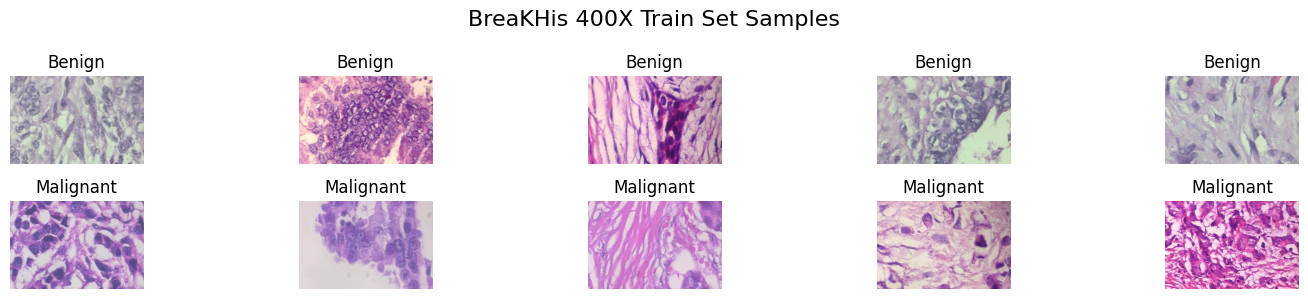

In [ ]:
benign_path = os.path.join(image_root, 'train', 'benign')
malignant_path = os.path.join(image_root, 'train', 'malignant')

benign_imgs = random.sample(os.listdir(benign_path), 5)
malignant_imgs = random.sample(os.listdir(malignant_path), 5)

# Plot benign
plt.figure(figsize=(15, 3))
for i, fname in enumerate(benign_imgs):
    img = Image.open(os.path.join(benign_path, fname))
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title("Benign")
    plt.axis("off")

# Plot malignant
for i, fname in enumerate(malignant_imgs):
    img = Image.open(os.path.join(malignant_path, fname))
    plt.subplot(2, 5, i+6)
    plt.imshow(img)
    plt.title("Malignant")
    plt.axis("off")

plt.suptitle("BreaKHis 400X Train Set Samples", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
sizes = Counter()
modes = Counter()

for split in ['train', 'test']:
    for cls in ['benign', 'malignant']:
        folder = os.path.join(image_root, split, cls)
        for fname in os.listdir(folder):
            if fname.endswith('.png'):
                img_path = os.path.join(folder, fname)
                try:
                    img = Image.open(img_path)
                    sizes[img.size] += 1
                    modes[img.mode] += 1
                except Exception as e:
                    print(f"Could not read image: {img_path} — {e}")

print("Image Sizes (Full Dataset):", sizes)
print("Image Modes (Full Dataset):", modes)

Image Sizes (Full Dataset): Counter({(700, 460): 1680, (700, 456): 13})
Image Modes (Full Dataset): Counter({'RGB': 1693})


In [ ]:
train_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dir = os.path.join(image_root, 'train')
test_dir = os.path.join(image_root, 'test')

train_dataset_resnet = datasets.ImageFolder(train_dir, transform=train_transform_resnet)
test_dataset_resnet  = datasets.ImageFolder(test_dir,  transform=test_transform_resnet)

train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=32, shuffle=True)
test_loader_resnet  = DataLoader(test_dataset_resnet,  batch_size=32, shuffle=False)

In [ ]:
resnet_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 1)   # output 1 logit

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

#criterion_resnet = nn.BCEWithLogitsLoss()
#change made

# Handle Class Imbalance using pos_weight
train_labels = [label for _, label in train_dataset_resnet.imgs]
benign_count = train_labels.count(0)
malignant_count = train_labels.count(1)
pos_weight = torch.tensor([benign_count / malignant_count]).to(device)
criterion_resnet = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer_resnet = torch.optim.Adam(resnet_model.parameters(), lr=1e-4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


In [ ]:
def train_model_logits(model, train_loader, criterion, optimizer, num_epochs=5):
    history = {"loss": [], "acc": []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)  # (B, 1)

            outputs = model(inputs)               # logits (B, 1)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # accuracy
            probs = torch.sigmoid(outputs)        # → (0,1)
            preds = (probs > 0.5).float()

            running_loss += loss.item() * inputs.size(0)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total

        history["loss"].append(epoch_loss)
        history["acc"].append(epoch_acc)

        print(f"[ResNet] Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

    return history

In [ ]:
def plot_history(history):
    epochs = range(1, len(history["loss"]) + 1)

    plt.figure(figsize=(10, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["loss"], 'b-o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["acc"], 'g-o')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

[ResNet] Epoch 1/5, Loss: 0.2752, Acc: 0.7683
[ResNet] Epoch 2/5, Loss: 0.1552, Acc: 0.9138
[ResNet] Epoch 3/5, Loss: 0.1125, Acc: 0.9364
[ResNet] Epoch 4/5, Loss: 0.0776, Acc: 0.9503
[ResNet] Epoch 5/5, Loss: 0.0766, Acc: 0.9564


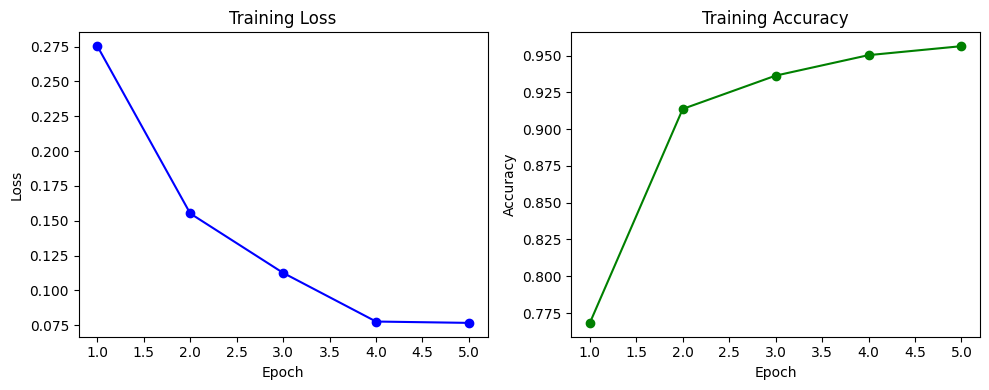

In [ ]:
history_resnet = train_model_logits(resnet_model, train_loader_resnet, criterion_resnet, optimizer_resnet, num_epochs=5)
plot_history(history_resnet)

In [ ]:
def evaluate_model_logits(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(inputs)          # logits
            probs = torch.sigmoid(outputs)   # (0,1)
            preds = (probs > 0.5).float()

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Test Accuracy (ResNet18): {correct / total:.4f}")

In [ ]:
evaluate_model_logits(resnet_model, test_loader_resnet)

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

In [ ]:
input_size = (3, 224, 224)
summary(resnet_model, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
def evaluate_with_confusion_logits(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true).astype(int).flatten()
    y_pred = np.array(y_pred).astype(int).flatten()

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["Benign", "Malignant"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix – ResNet18")
    plt.show()

    print("Classification Report – ResNet18:")
    print(classification_report(y_true, y_pred,
                                target_names=["Benign", "Malignant"]))

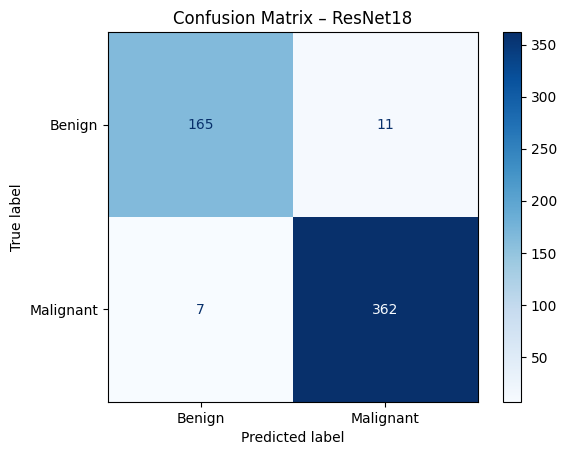

Classification Report – ResNet18:
              precision    recall  f1-score   support

      Benign       0.96      0.94      0.95       176
   Malignant       0.97      0.98      0.98       369

    accuracy                           0.97       545
   macro avg       0.96      0.96      0.96       545
weighted avg       0.97      0.97      0.97       545



In [ ]:
evaluate_with_confusion_logits(resnet_model, test_loader_resnet)

AUC Score (ResNet18 Test Set): 0.9919


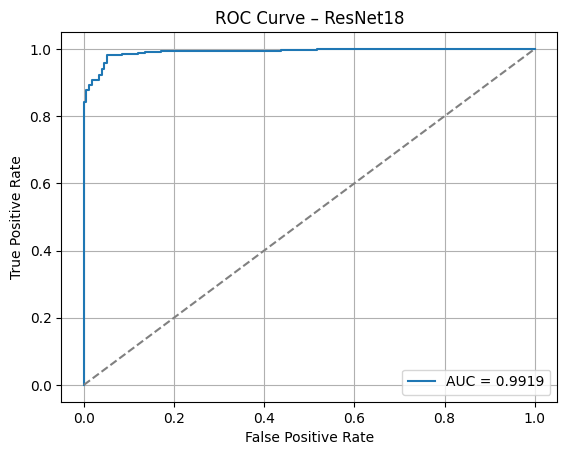

In [ ]:
# ROC Curve and AUC Score on Test Set
def plot_roc_auc(model, test_loader):
    model.eval()
    y_true = []
    y_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(inputs)
            probs = torch.sigmoid(outputs)

            y_true.extend(labels.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    y_true = np.array(y_true).astype(int).flatten()
    y_probs = np.array(y_probs).flatten()

    auc_score = roc_auc_score(y_true, y_probs)
    fpr, tpr, _ = roc_curve(y_true, y_probs)

    print(f"AUC Score (ResNet18 Test Set): {auc_score:.4f}")

    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve – ResNet18')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_roc_auc(resnet_model, test_loader_resnet)

In [ ]:
torch.save(resnet_model.state_dict(), 'breast_cancer_resnet18_v2.pth')
from google.colab import files
files.download('breast_cancer_resnet18_v2.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>